# ResNet Implementation with PyTorch


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torchsummary import summary

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from utils import train, test

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Download CIFAR10 & Define DataLoader

- `ToTensor()` transforms data into `Tensor` type and also normalizes into `[0,1]` range.

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

dataset = CIFAR10(root='', train=True, download=True, transform=transform)
testset = CIFAR10(root='', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(dataset.data.shape)
print(testset.data.shape)
print(dataset.classes)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
train_num = int(len(dataset)*0.9)
valid_num = len(dataset) - train_num

trainset, validset = random_split(dataset, [train_num, valid_num])

In [6]:
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=6)
validloader = DataLoader(validset, batch_size=100, shuffle=False, num_workers=6)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=6)

## Construct Blocks

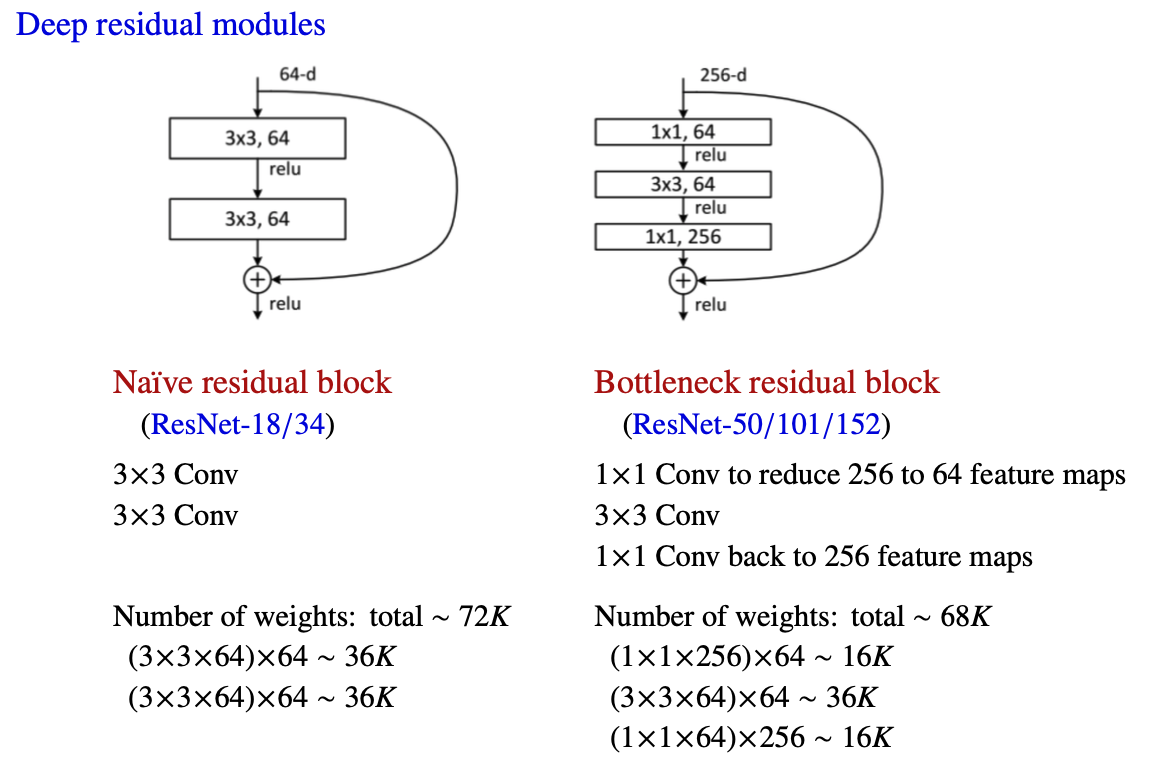

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(BasicBlock, self).__init__()
        
        self.residual = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=(3,3), stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(),
            nn.Conv2d(out_planes, out_planes, kernel_size=(3,3), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_planes)
        )
        
        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()
        
        if stride != 1 or in_planes != out_planes:
            self.shortcut.add_module('conv', nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=True))                                     
        
    def forward(self, x):
        x = self.residual(x) + self.shortcut(x)
        x = self.relu(x)
        return x
    

In [8]:
class BottleNeckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1):
        super(BottleNeckBlock, self).__init__()
        
        self.residual = nn.Sequential(
            nn.Conv2d(in_planes, out_planes//4, kernel_size=(1,1), stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(out_planes//4),
            nn.ReLU(),
            nn.Conv2d(out_planes//4, out_planes//4, kernel_size=(3,3), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_planes//4),
            nn.ReLU(),
            nn.Conv2d(out_planes//4, out_planes, kernel_size=(1,1), stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_planes)
        )
        
        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()
        
        if stride != 1 or in_planes != out_planes:
            self.shortcut.add_module('conv', nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=True))
            
    def forward(self, x):
        x = self.residual(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [9]:
class ResNet(nn.Module):
    def __init__(self, channels, init_weights=True, block='basic'):
        super(ResNet,self).__init__()
        
        self.conv = nn.Conv2d(3, channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(channels[0])
        self.relu = nn.ReLU()
        
        if block=='basic':
            self.block1 = BasicBlock(channels[0], channels[0], stride=1)
            self.block2 = BasicBlock(channels[0], channels[1], stride=2)
            self.block3 = BasicBlock(channels[1], channels[2], stride=1)
            self.block4 = BasicBlock(channels[2], channels[3], stride=2)
            self.block5 = BasicBlock(channels[3], channels[4], stride=2)
            self.block6 = BasicBlock(channels[4], channels[5], stride=1)
        
        elif block == 'bottleneck':
            self.block1 = BottleNeckBlock(channels[0], channels[0], stride=1)
            self.block2 = BottleNeckBlock(channels[0], channels[1], stride=2)
            self.block3 = BottleNeckBlock(channels[1], channels[2], stride=1)
            self.block4 = BottleNeckBlock(channels[2], channels[3], stride=2)
            self.block5 = BottleNeckBlock(channels[3], channels[4], stride=2)
            self.block6 = BottleNeckBlock(channels[4], channels[5], stride=1)
        
        else:
            raise ValueError
            
        self.avgpool = nn.AvgPool2d(kernel_size=(4,4))
        
        self.fc1 = nn.Linear(channels[5], channels[5]//4, bias=False)
        self.bn1 = nn.BatchNorm1d(channels[5]//4)
        self.fc2 = nn.Linear(channels[5]//4, 10, bias=True)
        
        if init_weights:
            self.initialize_weights()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        
        x = self.block1(x)      
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)        
        
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

In [10]:
basic_model = ResNet(channels=[16,16,32,64,128,128], block='basic').to(device)

In [11]:
summary(basic_model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
       BasicBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 16, 16]           2,304
      BatchNorm2d-12           [-1, 16, 16, 16]              32
             ReLU-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1, 16,

In [12]:
loss_ftn = nn.CrossEntropyLoss()
optimizer = optim.Adam(basic_model.parameters(), lr=0.01, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                              lr_lambda=lambda epoch: (0.5**int(epoch//10))*(0.95 ** epoch),
                                              verbose=1)

Adjusting learning rate of group 0 to 1.0000e-02.


In [13]:
EPOCHS=50

losses, accs, valid_losses, valid_accs = train(basic_model, trainloader, validloader, EPOCHS, device, 
                                               loss_ftn, optimizer, scheduler=scheduler)

352it [00:05, 61.55it/s]


EPOCH 1 Completed. 
 Training Loss: 1.618, Training Accuracy: 40.28, Validation Loss: 1.325, Validation Accuracy: 50.50 

Adjusting learning rate of group 0 to 9.5000e-03.


352it [00:05, 61.09it/s]


EPOCH 2 Completed. 
 Training Loss: 1.234, Training Accuracy: 54.94, Validation Loss: 1.232, Validation Accuracy: 55.94 

Adjusting learning rate of group 0 to 9.0250e-03.


352it [00:05, 61.27it/s]


EPOCH 3 Completed. 
 Training Loss: 1.101, Training Accuracy: 60.62, Validation Loss: 1.067, Validation Accuracy: 62.46 

Adjusting learning rate of group 0 to 8.5737e-03.


352it [00:05, 61.98it/s]


EPOCH 4 Completed. 
 Training Loss: 1.022, Training Accuracy: 63.62, Validation Loss: 0.996, Validation Accuracy: 65.26 

Adjusting learning rate of group 0 to 8.1451e-03.


352it [00:05, 60.86it/s]


EPOCH 5 Completed. 
 Training Loss: 0.952, Training Accuracy: 65.99, Validation Loss: 0.944, Validation Accuracy: 66.60 

Adjusting learning rate of group 0 to 7.7378e-03.


352it [00:05, 61.69it/s]


EPOCH 6 Completed. 
 Training Loss: 0.910, Training Accuracy: 67.78, Validation Loss: 0.889, Validation Accuracy: 69.30 

Adjusting learning rate of group 0 to 7.3509e-03.


352it [00:05, 61.05it/s]


EPOCH 7 Completed. 
 Training Loss: 0.870, Training Accuracy: 69.26, Validation Loss: 0.906, Validation Accuracy: 67.84 

Adjusting learning rate of group 0 to 6.9834e-03.


352it [00:05, 61.73it/s]


EPOCH 8 Completed. 
 Training Loss: 0.852, Training Accuracy: 69.82, Validation Loss: 0.874, Validation Accuracy: 69.96 

Adjusting learning rate of group 0 to 6.6342e-03.


352it [00:06, 53.93it/s]


EPOCH 9 Completed. 
 Training Loss: 0.816, Training Accuracy: 71.24, Validation Loss: 0.858, Validation Accuracy: 69.40 

Adjusting learning rate of group 0 to 6.3025e-03.


352it [00:06, 54.30it/s]


EPOCH 10 Completed. 
 Training Loss: 0.795, Training Accuracy: 72.08, Validation Loss: 0.817, Validation Accuracy: 71.14 

Adjusting learning rate of group 0 to 2.9937e-03.


352it [00:06, 53.48it/s]


EPOCH 11 Completed. 
 Training Loss: 0.687, Training Accuracy: 76.09, Validation Loss: 0.729, Validation Accuracy: 74.50 

Adjusting learning rate of group 0 to 2.8440e-03.


352it [00:06, 54.43it/s]


EPOCH 12 Completed. 
 Training Loss: 0.652, Training Accuracy: 77.32, Validation Loss: 0.717, Validation Accuracy: 74.80 

Adjusting learning rate of group 0 to 2.7018e-03.


352it [00:05, 63.22it/s]


EPOCH 13 Completed. 
 Training Loss: 0.630, Training Accuracy: 78.03, Validation Loss: 0.702, Validation Accuracy: 75.26 

Adjusting learning rate of group 0 to 2.5667e-03.


352it [00:06, 58.51it/s]


EPOCH 14 Completed. 
 Training Loss: 0.613, Training Accuracy: 78.60, Validation Loss: 0.691, Validation Accuracy: 75.58 

Adjusting learning rate of group 0 to 2.4384e-03.


352it [00:05, 60.96it/s]


EPOCH 15 Completed. 
 Training Loss: 0.590, Training Accuracy: 79.37, Validation Loss: 0.684, Validation Accuracy: 76.20 

Adjusting learning rate of group 0 to 2.3165e-03.


352it [00:05, 60.84it/s]


EPOCH 16 Completed. 
 Training Loss: 0.566, Training Accuracy: 80.34, Validation Loss: 0.666, Validation Accuracy: 76.50 

Adjusting learning rate of group 0 to 2.2006e-03.


352it [00:05, 61.66it/s]


EPOCH 17 Completed. 
 Training Loss: 0.547, Training Accuracy: 80.85, Validation Loss: 0.683, Validation Accuracy: 76.62 

Adjusting learning rate of group 0 to 2.0906e-03.


352it [00:05, 60.37it/s]


EPOCH 18 Completed. 
 Training Loss: 0.530, Training Accuracy: 81.50, Validation Loss: 0.685, Validation Accuracy: 76.60 

Adjusting learning rate of group 0 to 1.9861e-03.


352it [00:05, 60.98it/s]


EPOCH 19 Completed. 
 Training Loss: 0.517, Training Accuracy: 81.86, Validation Loss: 0.655, Validation Accuracy: 77.04 

Adjusting learning rate of group 0 to 1.8868e-03.


352it [00:06, 52.06it/s]


EPOCH 20 Completed. 
 Training Loss: 0.499, Training Accuracy: 82.60, Validation Loss: 0.667, Validation Accuracy: 77.12 

Adjusting learning rate of group 0 to 8.9621e-04.


352it [00:07, 49.64it/s]


EPOCH 21 Completed. 
 Training Loss: 0.418, Training Accuracy: 85.65, Validation Loss: 0.648, Validation Accuracy: 78.14 

Adjusting learning rate of group 0 to 8.5140e-04.


352it [00:06, 57.35it/s]


EPOCH 22 Completed. 
 Training Loss: 0.390, Training Accuracy: 86.62, Validation Loss: 0.657, Validation Accuracy: 77.98 

Adjusting learning rate of group 0 to 8.0883e-04.


352it [00:06, 58.27it/s]


EPOCH 23 Completed. 
 Training Loss: 0.373, Training Accuracy: 87.24, Validation Loss: 0.659, Validation Accuracy: 77.52 

Adjusting learning rate of group 0 to 7.6839e-04.


352it [00:06, 53.20it/s]


EPOCH 24 Completed. 
 Training Loss: 0.356, Training Accuracy: 87.78, Validation Loss: 0.661, Validation Accuracy: 77.80 

Adjusting learning rate of group 0 to 7.2997e-04.


352it [00:05, 59.21it/s]


EPOCH 25 Completed. 
 Training Loss: 0.339, Training Accuracy: 88.64, Validation Loss: 0.673, Validation Accuracy: 77.98 

Adjusting learning rate of group 0 to 6.9347e-04.


352it [00:05, 60.54it/s]


EPOCH 26 Completed. 
 Training Loss: 0.327, Training Accuracy: 88.73, Validation Loss: 0.679, Validation Accuracy: 77.92 

Adjusting learning rate of group 0 to 6.5880e-04.


352it [00:06, 51.79it/s]


EPOCH 27 Completed. 
 Training Loss: 0.308, Training Accuracy: 89.60, Validation Loss: 0.702, Validation Accuracy: 77.94 

Adjusting learning rate of group 0 to 6.2586e-04.


352it [00:06, 51.04it/s]


EPOCH 28 Completed. 
 Training Loss: 0.290, Training Accuracy: 90.14, Validation Loss: 0.717, Validation Accuracy: 76.94 

Adjusting learning rate of group 0 to 5.9457e-04.


352it [00:07, 49.09it/s]


EPOCH 29 Completed. 
 Training Loss: 0.282, Training Accuracy: 90.43, Validation Loss: 0.710, Validation Accuracy: 77.78 

Adjusting learning rate of group 0 to 5.6484e-04.


352it [00:07, 49.83it/s]


EPOCH 30 Completed. 
 Training Loss: 0.268, Training Accuracy: 91.06, Validation Loss: 0.730, Validation Accuracy: 77.48 

Adjusting learning rate of group 0 to 2.6830e-04.


352it [00:07, 49.75it/s]


EPOCH 31 Completed. 
 Training Loss: 0.225, Training Accuracy: 92.80, Validation Loss: 0.752, Validation Accuracy: 77.42 

Adjusting learning rate of group 0 to 2.5488e-04.


352it [00:06, 50.61it/s]


EPOCH 32 Completed. 
 Training Loss: 0.211, Training Accuracy: 93.41, Validation Loss: 0.755, Validation Accuracy: 77.60 

Adjusting learning rate of group 0 to 2.4214e-04.


352it [00:06, 50.42it/s]


EPOCH 33 Completed. 
 Training Loss: 0.203, Training Accuracy: 93.75, Validation Loss: 0.774, Validation Accuracy: 77.24 

Adjusting learning rate of group 0 to 2.3003e-04.


352it [00:06, 50.32it/s]


EPOCH 34 Completed. 
 Training Loss: 0.195, Training Accuracy: 93.91, Validation Loss: 0.790, Validation Accuracy: 76.78 

Adjusting learning rate of group 0 to 2.1853e-04.


352it [00:06, 53.51it/s]


EPOCH 35 Completed. 
 Training Loss: 0.189, Training Accuracy: 94.15, Validation Loss: 0.801, Validation Accuracy: 77.00 

Adjusting learning rate of group 0 to 2.0760e-04.


352it [00:07, 49.28it/s]


EPOCH 36 Completed. 
 Training Loss: 0.181, Training Accuracy: 94.49, Validation Loss: 0.809, Validation Accuracy: 77.08 

Adjusting learning rate of group 0 to 1.9722e-04.


352it [00:06, 53.54it/s]


EPOCH 37 Completed. 
 Training Loss: 0.175, Training Accuracy: 94.74, Validation Loss: 0.824, Validation Accuracy: 76.90 

Adjusting learning rate of group 0 to 1.8736e-04.


352it [00:06, 55.42it/s]


EPOCH 38 Completed. 
 Training Loss: 0.172, Training Accuracy: 94.86, Validation Loss: 0.833, Validation Accuracy: 76.86 

Adjusting learning rate of group 0 to 1.7799e-04.


352it [00:06, 51.29it/s]


EPOCH 39 Completed. 
 Training Loss: 0.163, Training Accuracy: 95.18, Validation Loss: 0.842, Validation Accuracy: 76.88 

Adjusting learning rate of group 0 to 1.6909e-04.


352it [00:06, 58.28it/s]


EPOCH 40 Completed. 
 Training Loss: 0.159, Training Accuracy: 95.24, Validation Loss: 0.851, Validation Accuracy: 76.88 

Adjusting learning rate of group 0 to 8.0320e-05.


352it [00:06, 51.40it/s]


EPOCH 41 Completed. 
 Training Loss: 0.144, Training Accuracy: 95.98, Validation Loss: 0.859, Validation Accuracy: 76.80 

Adjusting learning rate of group 0 to 7.6304e-05.


352it [00:05, 59.86it/s]


EPOCH 42 Completed. 
 Training Loss: 0.139, Training Accuracy: 96.24, Validation Loss: 0.871, Validation Accuracy: 76.54 

Adjusting learning rate of group 0 to 7.2489e-05.


352it [00:05, 59.48it/s]


EPOCH 43 Completed. 
 Training Loss: 0.136, Training Accuracy: 96.32, Validation Loss: 0.876, Validation Accuracy: 76.54 

Adjusting learning rate of group 0 to 6.8864e-05.


352it [00:05, 61.60it/s]


EPOCH 44 Completed. 
 Training Loss: 0.134, Training Accuracy: 96.39, Validation Loss: 0.882, Validation Accuracy: 76.50 

Adjusting learning rate of group 0 to 6.5421e-05.


352it [00:05, 62.34it/s]


EPOCH 45 Completed. 
 Training Loss: 0.131, Training Accuracy: 96.48, Validation Loss: 0.888, Validation Accuracy: 76.32 

Adjusting learning rate of group 0 to 6.2150e-05.


352it [00:06, 55.56it/s]


EPOCH 46 Completed. 
 Training Loss: 0.128, Training Accuracy: 96.68, Validation Loss: 0.890, Validation Accuracy: 76.38 

Adjusting learning rate of group 0 to 5.9043e-05.


352it [00:05, 61.20it/s]


EPOCH 47 Completed. 
 Training Loss: 0.125, Training Accuracy: 96.80, Validation Loss: 0.898, Validation Accuracy: 76.30 

Adjusting learning rate of group 0 to 5.6091e-05.


352it [00:05, 61.33it/s]


EPOCH 48 Completed. 
 Training Loss: 0.124, Training Accuracy: 96.85, Validation Loss: 0.902, Validation Accuracy: 76.44 

Adjusting learning rate of group 0 to 5.3286e-05.


352it [00:05, 61.99it/s]


EPOCH 49 Completed. 
 Training Loss: 0.123, Training Accuracy: 96.78, Validation Loss: 0.903, Validation Accuracy: 76.22 

Adjusting learning rate of group 0 to 5.0622e-05.


352it [00:05, 63.24it/s]


EPOCH 50 Completed. 
 Training Loss: 0.121, Training Accuracy: 96.92, Validation Loss: 0.909, Validation Accuracy: 76.36 

Adjusting learning rate of group 0 to 2.4045e-05.


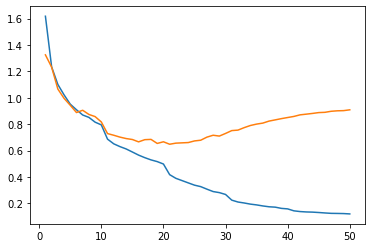

In [14]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), losses, label='training loss')
plt.plot(np.arange(1, EPOCHS+1), valid_losses, label='validation loss')
plt.show()

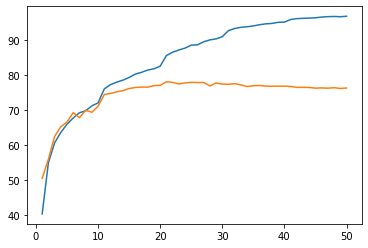

In [15]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), accs, label='training accuracy')
plt.plot(np.arange(1, EPOCHS+1), valid_accs, label='validation accuracy')
plt.show()

In [16]:
test(basic_model, testloader, device)

Accuracy of the network on 10000 test images: 76.22 %


In [17]:
bottleneck_model = ResNet(channels=[16,16,32,64,128,128], block='bottleneck').to(device)

In [18]:
summary(bottleneck_model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4            [-1, 4, 32, 32]              64
       BatchNorm2d-5            [-1, 4, 32, 32]               8
              ReLU-6            [-1, 4, 32, 32]               0
            Conv2d-7            [-1, 4, 32, 32]             144
       BatchNorm2d-8            [-1, 4, 32, 32]               8
              ReLU-9            [-1, 4, 32, 32]               0
           Conv2d-10           [-1, 16, 32, 32]              64
      BatchNorm2d-11           [-1, 16, 32, 32]              32
             ReLU-12           [-1, 16, 32, 32]               0
  BottleNeckBlock-13           [-1, 16, 32, 32]               0
           Conv2d-14            [-1, 4,

In [19]:
loss_ftn = nn.CrossEntropyLoss()
optimizer = optim.Adam(bottleneck_model.parameters(), lr=0.01, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                              lr_lambda=lambda epoch: (0.5**int(epoch//10))*(0.95 ** epoch),
                                              verbose=1)

Adjusting learning rate of group 0 to 1.0000e-02.


In [20]:
EPOCHS=50

losses, accs, valid_losses, valid_accs = train(bottleneck_model, trainloader, validloader, EPOCHS, device, 
                                               loss_ftn, optimizer, scheduler=scheduler)

352it [00:07, 48.37it/s]


EPOCH 1 Completed. 
 Training Loss: 1.730, Training Accuracy: 35.47, Validation Loss: 1.486, Validation Accuracy: 45.16 

Adjusting learning rate of group 0 to 9.5000e-03.


352it [00:07, 46.04it/s]


EPOCH 2 Completed. 
 Training Loss: 1.436, Training Accuracy: 47.11, Validation Loss: 1.322, Validation Accuracy: 51.54 

Adjusting learning rate of group 0 to 9.0250e-03.


352it [00:07, 48.21it/s]


EPOCH 3 Completed. 
 Training Loss: 1.320, Training Accuracy: 51.78, Validation Loss: 1.316, Validation Accuracy: 52.50 

Adjusting learning rate of group 0 to 8.5737e-03.


352it [00:07, 48.02it/s]


EPOCH 4 Completed. 
 Training Loss: 1.256, Training Accuracy: 54.10, Validation Loss: 1.230, Validation Accuracy: 55.54 

Adjusting learning rate of group 0 to 8.1451e-03.


352it [00:07, 48.26it/s]


EPOCH 5 Completed. 
 Training Loss: 1.199, Training Accuracy: 56.41, Validation Loss: 1.183, Validation Accuracy: 57.18 

Adjusting learning rate of group 0 to 7.7378e-03.


352it [00:07, 47.55it/s]


EPOCH 6 Completed. 
 Training Loss: 1.154, Training Accuracy: 58.57, Validation Loss: 1.182, Validation Accuracy: 56.94 

Adjusting learning rate of group 0 to 7.3509e-03.


352it [00:07, 47.83it/s]


EPOCH 7 Completed. 
 Training Loss: 1.123, Training Accuracy: 59.44, Validation Loss: 1.108, Validation Accuracy: 59.92 

Adjusting learning rate of group 0 to 6.9834e-03.


352it [00:07, 48.12it/s]


EPOCH 8 Completed. 
 Training Loss: 1.094, Training Accuracy: 60.63, Validation Loss: 1.099, Validation Accuracy: 60.74 

Adjusting learning rate of group 0 to 6.6342e-03.


352it [00:07, 47.72it/s]


EPOCH 9 Completed. 
 Training Loss: 1.064, Training Accuracy: 61.89, Validation Loss: 1.092, Validation Accuracy: 61.12 

Adjusting learning rate of group 0 to 6.3025e-03.


352it [00:07, 46.43it/s]


EPOCH 10 Completed. 
 Training Loss: 1.040, Training Accuracy: 62.69, Validation Loss: 1.051, Validation Accuracy: 62.52 

Adjusting learning rate of group 0 to 2.9937e-03.


352it [00:07, 47.74it/s]


EPOCH 11 Completed. 
 Training Loss: 0.951, Training Accuracy: 65.97, Validation Loss: 1.002, Validation Accuracy: 63.88 

Adjusting learning rate of group 0 to 2.8440e-03.


352it [00:07, 48.66it/s]


EPOCH 12 Completed. 
 Training Loss: 0.919, Training Accuracy: 67.24, Validation Loss: 0.949, Validation Accuracy: 66.32 

Adjusting learning rate of group 0 to 2.7018e-03.


352it [00:07, 46.41it/s]


EPOCH 13 Completed. 
 Training Loss: 0.896, Training Accuracy: 68.02, Validation Loss: 0.945, Validation Accuracy: 66.40 

Adjusting learning rate of group 0 to 2.5667e-03.


352it [00:07, 45.84it/s]


EPOCH 14 Completed. 
 Training Loss: 0.881, Training Accuracy: 68.83, Validation Loss: 0.935, Validation Accuracy: 66.88 

Adjusting learning rate of group 0 to 2.4384e-03.


352it [00:07, 47.17it/s]


EPOCH 15 Completed. 
 Training Loss: 0.868, Training Accuracy: 69.18, Validation Loss: 0.920, Validation Accuracy: 67.00 

Adjusting learning rate of group 0 to 2.3165e-03.


352it [00:07, 47.78it/s]


EPOCH 16 Completed. 
 Training Loss: 0.849, Training Accuracy: 69.86, Validation Loss: 0.903, Validation Accuracy: 68.30 

Adjusting learning rate of group 0 to 2.2006e-03.


352it [00:07, 46.54it/s]


EPOCH 17 Completed. 
 Training Loss: 0.830, Training Accuracy: 70.76, Validation Loss: 0.901, Validation Accuracy: 67.82 

Adjusting learning rate of group 0 to 2.0906e-03.


352it [00:07, 49.61it/s]


EPOCH 18 Completed. 
 Training Loss: 0.820, Training Accuracy: 71.08, Validation Loss: 0.891, Validation Accuracy: 68.16 

Adjusting learning rate of group 0 to 1.9861e-03.


352it [00:07, 48.08it/s]


EPOCH 19 Completed. 
 Training Loss: 0.810, Training Accuracy: 71.26, Validation Loss: 0.890, Validation Accuracy: 68.38 

Adjusting learning rate of group 0 to 1.8868e-03.


352it [00:07, 45.71it/s]


EPOCH 20 Completed. 
 Training Loss: 0.792, Training Accuracy: 72.12, Validation Loss: 0.883, Validation Accuracy: 68.32 

Adjusting learning rate of group 0 to 8.9621e-04.


352it [00:08, 43.71it/s]


EPOCH 21 Completed. 
 Training Loss: 0.738, Training Accuracy: 74.01, Validation Loss: 0.857, Validation Accuracy: 69.64 

Adjusting learning rate of group 0 to 8.5140e-04.


352it [00:08, 42.23it/s]


EPOCH 22 Completed. 
 Training Loss: 0.723, Training Accuracy: 74.60, Validation Loss: 0.854, Validation Accuracy: 69.30 

Adjusting learning rate of group 0 to 8.0883e-04.


352it [00:08, 41.93it/s]


EPOCH 23 Completed. 
 Training Loss: 0.711, Training Accuracy: 75.02, Validation Loss: 0.857, Validation Accuracy: 69.66 

Adjusting learning rate of group 0 to 7.6839e-04.


352it [00:07, 45.42it/s]


EPOCH 24 Completed. 
 Training Loss: 0.702, Training Accuracy: 75.29, Validation Loss: 0.857, Validation Accuracy: 69.42 

Adjusting learning rate of group 0 to 7.2997e-04.


352it [00:07, 48.64it/s]


EPOCH 25 Completed. 
 Training Loss: 0.692, Training Accuracy: 75.60, Validation Loss: 0.863, Validation Accuracy: 69.82 

Adjusting learning rate of group 0 to 6.9347e-04.


352it [00:07, 49.18it/s]


EPOCH 26 Completed. 
 Training Loss: 0.683, Training Accuracy: 76.06, Validation Loss: 0.857, Validation Accuracy: 69.88 

Adjusting learning rate of group 0 to 6.5880e-04.


352it [00:07, 47.83it/s]


EPOCH 27 Completed. 
 Training Loss: 0.678, Training Accuracy: 76.25, Validation Loss: 0.857, Validation Accuracy: 69.72 

Adjusting learning rate of group 0 to 6.2586e-04.


352it [00:07, 47.83it/s]


EPOCH 28 Completed. 
 Training Loss: 0.670, Training Accuracy: 76.47, Validation Loss: 0.863, Validation Accuracy: 69.96 

Adjusting learning rate of group 0 to 5.9457e-04.


352it [00:07, 47.59it/s]


EPOCH 29 Completed. 
 Training Loss: 0.663, Training Accuracy: 76.68, Validation Loss: 0.864, Validation Accuracy: 69.60 

Adjusting learning rate of group 0 to 5.6484e-04.


352it [00:07, 48.30it/s]


EPOCH 30 Completed. 
 Training Loss: 0.657, Training Accuracy: 76.91, Validation Loss: 0.860, Validation Accuracy: 69.84 

Adjusting learning rate of group 0 to 2.6830e-04.


352it [00:07, 47.51it/s]


EPOCH 31 Completed. 
 Training Loss: 0.634, Training Accuracy: 77.86, Validation Loss: 0.855, Validation Accuracy: 69.98 

Adjusting learning rate of group 0 to 2.5488e-04.


352it [00:07, 48.27it/s]


EPOCH 32 Completed. 
 Training Loss: 0.627, Training Accuracy: 78.05, Validation Loss: 0.854, Validation Accuracy: 70.40 

Adjusting learning rate of group 0 to 2.4214e-04.


352it [00:07, 49.01it/s]


EPOCH 33 Completed. 
 Training Loss: 0.620, Training Accuracy: 78.46, Validation Loss: 0.855, Validation Accuracy: 69.72 

Adjusting learning rate of group 0 to 2.3003e-04.


352it [00:07, 46.09it/s]


EPOCH 34 Completed. 
 Training Loss: 0.619, Training Accuracy: 78.42, Validation Loss: 0.859, Validation Accuracy: 70.12 

Adjusting learning rate of group 0 to 2.1853e-04.


352it [00:07, 47.51it/s]


EPOCH 35 Completed. 
 Training Loss: 0.615, Training Accuracy: 78.54, Validation Loss: 0.861, Validation Accuracy: 69.88 

Adjusting learning rate of group 0 to 2.0760e-04.


352it [00:07, 48.39it/s]


EPOCH 36 Completed. 
 Training Loss: 0.610, Training Accuracy: 78.83, Validation Loss: 0.861, Validation Accuracy: 70.24 

Adjusting learning rate of group 0 to 1.9722e-04.


352it [00:07, 48.05it/s]


EPOCH 37 Completed. 
 Training Loss: 0.608, Training Accuracy: 78.78, Validation Loss: 0.866, Validation Accuracy: 70.20 

Adjusting learning rate of group 0 to 1.8736e-04.


352it [00:07, 48.99it/s]


EPOCH 38 Completed. 
 Training Loss: 0.607, Training Accuracy: 78.93, Validation Loss: 0.863, Validation Accuracy: 70.38 

Adjusting learning rate of group 0 to 1.7799e-04.


352it [00:07, 46.02it/s]


EPOCH 39 Completed. 
 Training Loss: 0.603, Training Accuracy: 79.02, Validation Loss: 0.865, Validation Accuracy: 70.00 

Adjusting learning rate of group 0 to 1.6909e-04.


352it [00:07, 48.01it/s]


EPOCH 40 Completed. 
 Training Loss: 0.603, Training Accuracy: 78.94, Validation Loss: 0.867, Validation Accuracy: 69.78 

Adjusting learning rate of group 0 to 8.0320e-05.


352it [00:07, 46.99it/s]


EPOCH 41 Completed. 
 Training Loss: 0.592, Training Accuracy: 79.34, Validation Loss: 0.865, Validation Accuracy: 70.14 

Adjusting learning rate of group 0 to 7.6304e-05.


352it [00:07, 47.58it/s]


EPOCH 42 Completed. 
 Training Loss: 0.591, Training Accuracy: 79.44, Validation Loss: 0.867, Validation Accuracy: 69.82 

Adjusting learning rate of group 0 to 7.2489e-05.


352it [00:07, 46.71it/s]


EPOCH 43 Completed. 
 Training Loss: 0.591, Training Accuracy: 79.36, Validation Loss: 0.867, Validation Accuracy: 70.10 

Adjusting learning rate of group 0 to 6.8864e-05.


352it [00:07, 47.44it/s]


EPOCH 44 Completed. 
 Training Loss: 0.588, Training Accuracy: 79.52, Validation Loss: 0.868, Validation Accuracy: 70.14 

Adjusting learning rate of group 0 to 6.5421e-05.


352it [00:07, 46.54it/s]


EPOCH 45 Completed. 
 Training Loss: 0.589, Training Accuracy: 79.59, Validation Loss: 0.869, Validation Accuracy: 70.18 

Adjusting learning rate of group 0 to 6.2150e-05.


352it [00:07, 48.66it/s]


EPOCH 46 Completed. 
 Training Loss: 0.587, Training Accuracy: 79.73, Validation Loss: 0.869, Validation Accuracy: 70.40 

Adjusting learning rate of group 0 to 5.9043e-05.


352it [00:07, 46.25it/s]


EPOCH 47 Completed. 
 Training Loss: 0.584, Training Accuracy: 79.59, Validation Loss: 0.869, Validation Accuracy: 70.04 

Adjusting learning rate of group 0 to 5.6091e-05.


352it [00:08, 42.59it/s]


EPOCH 48 Completed. 
 Training Loss: 0.583, Training Accuracy: 79.75, Validation Loss: 0.870, Validation Accuracy: 70.22 

Adjusting learning rate of group 0 to 5.3286e-05.


352it [00:08, 43.53it/s]


EPOCH 49 Completed. 
 Training Loss: 0.583, Training Accuracy: 79.78, Validation Loss: 0.872, Validation Accuracy: 70.06 

Adjusting learning rate of group 0 to 5.0622e-05.


352it [00:08, 42.44it/s]


EPOCH 50 Completed. 
 Training Loss: 0.583, Training Accuracy: 79.72, Validation Loss: 0.872, Validation Accuracy: 69.98 

Adjusting learning rate of group 0 to 2.4045e-05.


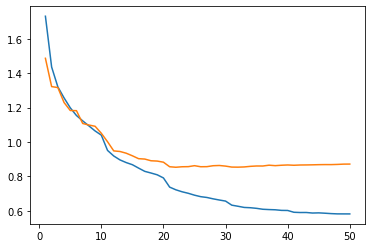

In [21]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), losses, label='training loss')
plt.plot(np.arange(1, EPOCHS+1), valid_losses, label='validation loss')
plt.show()

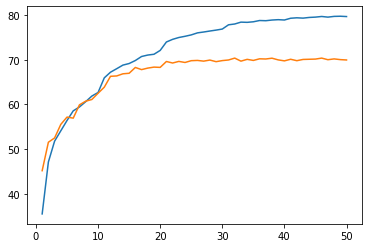

In [22]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), accs, label='training accuracy')
plt.plot(np.arange(1, EPOCHS+1), valid_accs, label='validation accuracy')
plt.show()

In [23]:
test(bottleneck_model, testloader, device)

Accuracy of the network on 10000 test images: 70.29 %


In [62]:
import resnet

In [63]:
resnet18 = resnet.resnet18().to(device)

In [64]:
summary(resnet18, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,800
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [65]:
loss_ftn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.01, weight_decay=0.001)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: (0.95 ** epoch) * (0.5 ** int(epoch//5)),
#                                         last_epoch=-1,
#                                         verbose=True)

# optimizer = optim.SGD(resnet18.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [66]:
EPOCHS=60

losses, accs, valid_losses, valid_accs = train(resnet18, trainloader, validloader, EPOCHS, device, 
                                               loss_ftn, optimizer, scheduler=scheduler)

352it [00:08, 39.79it/s]


EPOCH 1 Completed. 
 Training Loss: 1.624, Training Accuracy: 39.14, Validation Loss: 1.412, Validation Accuracy: 47.34 

Adjusting learning rate of group 0 to 9.9994e-03.


352it [00:08, 39.64it/s]


EPOCH 2 Completed. 
 Training Loss: 1.308, Training Accuracy: 52.21, Validation Loss: 1.284, Validation Accuracy: 53.82 

Adjusting learning rate of group 0 to 9.9975e-03.


352it [00:09, 38.94it/s]


EPOCH 3 Completed. 
 Training Loss: 1.201, Training Accuracy: 56.60, Validation Loss: 1.235, Validation Accuracy: 55.74 

Adjusting learning rate of group 0 to 9.9944e-03.


352it [00:08, 39.43it/s]


EPOCH 4 Completed. 
 Training Loss: 1.138, Training Accuracy: 59.07, Validation Loss: 1.161, Validation Accuracy: 58.34 

Adjusting learning rate of group 0 to 9.9901e-03.


352it [00:09, 39.11it/s]


EPOCH 5 Completed. 
 Training Loss: 1.105, Training Accuracy: 60.29, Validation Loss: 1.084, Validation Accuracy: 60.64 

Adjusting learning rate of group 0 to 9.9846e-03.


352it [00:10, 32.28it/s]


EPOCH 6 Completed. 
 Training Loss: 1.070, Training Accuracy: 61.79, Validation Loss: 1.100, Validation Accuracy: 60.30 

Adjusting learning rate of group 0 to 9.9778e-03.


352it [00:12, 28.89it/s]


EPOCH 7 Completed. 
 Training Loss: 1.044, Training Accuracy: 62.49, Validation Loss: 1.081, Validation Accuracy: 61.86 

Adjusting learning rate of group 0 to 9.9698e-03.


352it [00:11, 29.40it/s]


EPOCH 8 Completed. 
 Training Loss: 1.021, Training Accuracy: 63.37, Validation Loss: 1.074, Validation Accuracy: 60.84 

Adjusting learning rate of group 0 to 9.9606e-03.


352it [00:12, 28.96it/s]


EPOCH 9 Completed. 
 Training Loss: 0.999, Training Accuracy: 64.39, Validation Loss: 1.056, Validation Accuracy: 61.80 

Adjusting learning rate of group 0 to 9.9501e-03.


352it [00:12, 28.84it/s]


EPOCH 10 Completed. 
 Training Loss: 0.982, Training Accuracy: 65.12, Validation Loss: 1.056, Validation Accuracy: 62.58 

Adjusting learning rate of group 0 to 9.9384e-03.


352it [00:12, 29.12it/s]


EPOCH 11 Completed. 
 Training Loss: 0.962, Training Accuracy: 66.01, Validation Loss: 0.974, Validation Accuracy: 65.62 

Adjusting learning rate of group 0 to 9.9255e-03.


352it [00:12, 28.51it/s]


EPOCH 12 Completed. 
 Training Loss: 0.947, Training Accuracy: 66.58, Validation Loss: 0.984, Validation Accuracy: 65.16 

Adjusting learning rate of group 0 to 9.9114e-03.


352it [00:12, 28.76it/s]


EPOCH 13 Completed. 
 Training Loss: 0.937, Training Accuracy: 67.00, Validation Loss: 0.987, Validation Accuracy: 65.68 

Adjusting learning rate of group 0 to 9.8961e-03.


352it [00:12, 28.82it/s]


EPOCH 14 Completed. 
 Training Loss: 0.934, Training Accuracy: 67.06, Validation Loss: 0.966, Validation Accuracy: 66.60 

Adjusting learning rate of group 0 to 9.8796e-03.


352it [00:12, 28.89it/s]


EPOCH 15 Completed. 
 Training Loss: 0.925, Training Accuracy: 67.53, Validation Loss: 0.947, Validation Accuracy: 66.50 

Adjusting learning rate of group 0 to 9.8618e-03.


352it [00:12, 28.72it/s]


EPOCH 16 Completed. 
 Training Loss: 0.921, Training Accuracy: 67.54, Validation Loss: 0.949, Validation Accuracy: 66.32 

Adjusting learning rate of group 0 to 9.8429e-03.


352it [00:12, 28.69it/s]


EPOCH 17 Completed. 
 Training Loss: 0.914, Training Accuracy: 67.77, Validation Loss: 0.913, Validation Accuracy: 67.84 

Adjusting learning rate of group 0 to 9.8228e-03.


352it [00:12, 28.64it/s]


EPOCH 18 Completed. 
 Training Loss: 0.903, Training Accuracy: 68.28, Validation Loss: 0.952, Validation Accuracy: 67.08 

Adjusting learning rate of group 0 to 9.8015e-03.


352it [00:12, 28.62it/s]


EPOCH 19 Completed. 
 Training Loss: 0.898, Training Accuracy: 68.34, Validation Loss: 0.940, Validation Accuracy: 66.66 

Adjusting learning rate of group 0 to 9.7790e-03.


352it [00:12, 28.55it/s]


EPOCH 20 Completed. 
 Training Loss: 0.893, Training Accuracy: 68.54, Validation Loss: 0.959, Validation Accuracy: 66.54 

Adjusting learning rate of group 0 to 9.7553e-03.


352it [00:12, 28.76it/s]


EPOCH 21 Completed. 
 Training Loss: 0.887, Training Accuracy: 69.00, Validation Loss: 0.925, Validation Accuracy: 66.88 

Adjusting learning rate of group 0 to 9.7304e-03.


352it [00:12, 28.68it/s]


EPOCH 22 Completed. 
 Training Loss: 0.878, Training Accuracy: 69.20, Validation Loss: 0.915, Validation Accuracy: 68.30 

Adjusting learning rate of group 0 to 9.7044e-03.


352it [00:12, 28.60it/s]


EPOCH 23 Completed. 
 Training Loss: 0.880, Training Accuracy: 69.21, Validation Loss: 0.900, Validation Accuracy: 68.96 

Adjusting learning rate of group 0 to 9.6772e-03.


352it [00:12, 28.99it/s]


EPOCH 24 Completed. 
 Training Loss: 0.873, Training Accuracy: 69.62, Validation Loss: 0.928, Validation Accuracy: 67.10 

Adjusting learning rate of group 0 to 9.6489e-03.


352it [00:12, 28.74it/s]


EPOCH 25 Completed. 
 Training Loss: 0.868, Training Accuracy: 69.68, Validation Loss: 0.911, Validation Accuracy: 67.90 

Adjusting learning rate of group 0 to 9.6194e-03.


352it [00:12, 28.60it/s]


EPOCH 26 Completed. 
 Training Loss: 0.872, Training Accuracy: 69.35, Validation Loss: 0.936, Validation Accuracy: 66.94 

Adjusting learning rate of group 0 to 9.5888e-03.


352it [00:12, 28.86it/s]


EPOCH 27 Completed. 
 Training Loss: 0.870, Training Accuracy: 69.40, Validation Loss: 0.921, Validation Accuracy: 67.04 

Adjusting learning rate of group 0 to 9.5570e-03.


352it [00:12, 28.29it/s]


EPOCH 28 Completed. 
 Training Loss: 0.872, Training Accuracy: 69.46, Validation Loss: 0.960, Validation Accuracy: 65.82 

Adjusting learning rate of group 0 to 9.5241e-03.


352it [00:12, 29.21it/s]


EPOCH 29 Completed. 
 Training Loss: 0.859, Training Accuracy: 69.85, Validation Loss: 0.935, Validation Accuracy: 67.74 

Adjusting learning rate of group 0 to 9.4901e-03.


352it [00:12, 29.15it/s]


EPOCH 30 Completed. 
 Training Loss: 0.862, Training Accuracy: 69.86, Validation Loss: 0.941, Validation Accuracy: 66.94 

Adjusting learning rate of group 0 to 9.4550e-03.


352it [00:12, 29.14it/s]


EPOCH 31 Completed. 
 Training Loss: 0.855, Training Accuracy: 69.98, Validation Loss: 0.936, Validation Accuracy: 67.24 

Adjusting learning rate of group 0 to 9.4188e-03.


352it [00:12, 28.82it/s]


EPOCH 32 Completed. 
 Training Loss: 0.856, Training Accuracy: 69.96, Validation Loss: 0.925, Validation Accuracy: 67.74 

Adjusting learning rate of group 0 to 9.3815e-03.


352it [00:12, 28.86it/s]


EPOCH 33 Completed. 
 Training Loss: 0.851, Training Accuracy: 70.23, Validation Loss: 0.949, Validation Accuracy: 67.46 

Adjusting learning rate of group 0 to 9.3432e-03.


352it [00:12, 28.93it/s]


EPOCH 34 Completed. 
 Training Loss: 0.859, Training Accuracy: 69.90, Validation Loss: 0.891, Validation Accuracy: 68.70 

Adjusting learning rate of group 0 to 9.3037e-03.


352it [00:12, 29.27it/s]


EPOCH 35 Completed. 
 Training Loss: 0.859, Training Accuracy: 70.02, Validation Loss: 0.948, Validation Accuracy: 66.92 

Adjusting learning rate of group 0 to 9.2632e-03.


352it [00:12, 29.24it/s]


EPOCH 36 Completed. 
 Training Loss: 0.851, Training Accuracy: 70.51, Validation Loss: 0.908, Validation Accuracy: 68.54 

Adjusting learning rate of group 0 to 9.2216e-03.


352it [00:12, 29.25it/s]


EPOCH 37 Completed. 
 Training Loss: 0.843, Training Accuracy: 70.58, Validation Loss: 0.897, Validation Accuracy: 69.30 

Adjusting learning rate of group 0 to 9.1790e-03.


352it [00:12, 28.60it/s]


EPOCH 38 Completed. 
 Training Loss: 0.841, Training Accuracy: 70.54, Validation Loss: 0.927, Validation Accuracy: 68.06 

Adjusting learning rate of group 0 to 9.1354e-03.


352it [00:12, 29.02it/s]


EPOCH 39 Completed. 
 Training Loss: 0.849, Training Accuracy: 70.31, Validation Loss: 0.872, Validation Accuracy: 69.20 

Adjusting learning rate of group 0 to 9.0907e-03.


352it [00:12, 28.54it/s]


EPOCH 40 Completed. 
 Training Loss: 0.840, Training Accuracy: 70.63, Validation Loss: 0.862, Validation Accuracy: 70.22 

Adjusting learning rate of group 0 to 9.0451e-03.


352it [00:12, 28.56it/s]


EPOCH 41 Completed. 
 Training Loss: 0.843, Training Accuracy: 70.51, Validation Loss: 0.943, Validation Accuracy: 68.20 

Adjusting learning rate of group 0 to 8.9984e-03.


352it [00:12, 28.88it/s]


EPOCH 42 Completed. 
 Training Loss: 0.844, Training Accuracy: 70.55, Validation Loss: 0.927, Validation Accuracy: 68.12 

Adjusting learning rate of group 0 to 8.9508e-03.


352it [00:11, 29.39it/s]


EPOCH 43 Completed. 
 Training Loss: 0.834, Training Accuracy: 71.02, Validation Loss: 0.904, Validation Accuracy: 68.76 

Adjusting learning rate of group 0 to 8.9022e-03.


352it [00:12, 28.57it/s]


EPOCH 44 Completed. 
 Training Loss: 0.836, Training Accuracy: 70.68, Validation Loss: 0.899, Validation Accuracy: 68.60 

Adjusting learning rate of group 0 to 8.8526e-03.


352it [00:12, 28.86it/s]


EPOCH 45 Completed. 
 Training Loss: 0.836, Training Accuracy: 70.68, Validation Loss: 0.911, Validation Accuracy: 67.96 

Adjusting learning rate of group 0 to 8.8020e-03.


352it [00:12, 28.14it/s]


EPOCH 46 Completed. 
 Training Loss: 0.831, Training Accuracy: 71.16, Validation Loss: 0.910, Validation Accuracy: 69.28 

Adjusting learning rate of group 0 to 8.7506e-03.


352it [00:12, 27.85it/s]


EPOCH 47 Completed. 
 Training Loss: 0.829, Training Accuracy: 71.01, Validation Loss: 0.905, Validation Accuracy: 68.28 

Adjusting learning rate of group 0 to 8.6982e-03.


352it [00:12, 27.74it/s]


EPOCH 48 Completed. 
 Training Loss: 0.832, Training Accuracy: 71.06, Validation Loss: 0.884, Validation Accuracy: 69.48 

Adjusting learning rate of group 0 to 8.6448e-03.


352it [00:12, 28.05it/s]


EPOCH 49 Completed. 
 Training Loss: 0.832, Training Accuracy: 70.74, Validation Loss: 0.899, Validation Accuracy: 68.86 

Adjusting learning rate of group 0 to 8.5906e-03.


352it [00:12, 28.00it/s]


EPOCH 50 Completed. 
 Training Loss: 0.828, Training Accuracy: 71.18, Validation Loss: 0.886, Validation Accuracy: 68.70 

Adjusting learning rate of group 0 to 8.5355e-03.


352it [00:12, 27.86it/s]


EPOCH 51 Completed. 
 Training Loss: 0.821, Training Accuracy: 71.27, Validation Loss: 0.904, Validation Accuracy: 68.68 

Adjusting learning rate of group 0 to 8.4796e-03.


352it [00:12, 28.16it/s]


EPOCH 52 Completed. 
 Training Loss: 0.815, Training Accuracy: 71.73, Validation Loss: 0.921, Validation Accuracy: 67.54 

Adjusting learning rate of group 0 to 8.4227e-03.


352it [00:12, 28.30it/s]


EPOCH 53 Completed. 
 Training Loss: 0.821, Training Accuracy: 71.28, Validation Loss: 0.894, Validation Accuracy: 68.80 

Adjusting learning rate of group 0 to 8.3651e-03.


352it [00:12, 28.54it/s]


EPOCH 54 Completed. 
 Training Loss: 0.814, Training Accuracy: 71.52, Validation Loss: 0.901, Validation Accuracy: 68.68 

Adjusting learning rate of group 0 to 8.3066e-03.


352it [00:12, 28.61it/s]


EPOCH 55 Completed. 
 Training Loss: 0.817, Training Accuracy: 71.42, Validation Loss: 0.882, Validation Accuracy: 69.28 

Adjusting learning rate of group 0 to 8.2472e-03.


352it [00:12, 28.86it/s]


EPOCH 56 Completed. 
 Training Loss: 0.812, Training Accuracy: 71.76, Validation Loss: 0.891, Validation Accuracy: 68.86 

Adjusting learning rate of group 0 to 8.1871e-03.


352it [00:12, 29.16it/s]


EPOCH 57 Completed. 
 Training Loss: 0.812, Training Accuracy: 71.64, Validation Loss: 0.872, Validation Accuracy: 69.98 

Adjusting learning rate of group 0 to 8.1262e-03.


352it [00:12, 29.06it/s]


EPOCH 58 Completed. 
 Training Loss: 0.817, Training Accuracy: 71.45, Validation Loss: 0.873, Validation Accuracy: 69.72 

Adjusting learning rate of group 0 to 8.0645e-03.


352it [00:12, 28.74it/s]


EPOCH 59 Completed. 
 Training Loss: 0.809, Training Accuracy: 71.78, Validation Loss: 0.860, Validation Accuracy: 70.02 

Adjusting learning rate of group 0 to 8.0021e-03.


352it [00:12, 28.74it/s]


EPOCH 60 Completed. 
 Training Loss: 0.804, Training Accuracy: 71.94, Validation Loss: 0.882, Validation Accuracy: 69.62 

Adjusting learning rate of group 0 to 7.9389e-03.


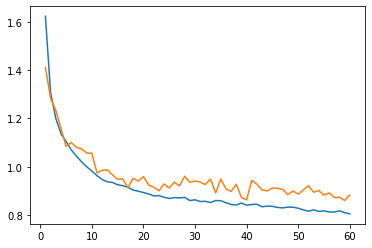

In [67]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), losses, label='training loss')
plt.plot(np.arange(1, EPOCHS+1), valid_losses, label='validation loss')
plt.show()

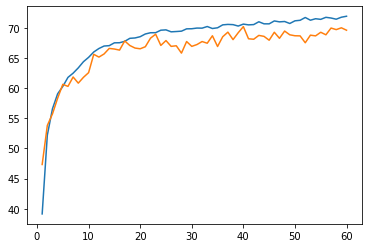

In [68]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), accs, label='training accuracy')
plt.plot(np.arange(1, EPOCHS+1), valid_accs, label='validation accuracy')
plt.show()

In [69]:
test(resnet18, testloader, device)

Accuracy of the network on 10000 test images: 70.45 %


In [34]:
resnet34 = resnet.resnet34().to(device)

In [35]:
summary(resnet34, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,800
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [36]:
loss_ftn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet34.parameters(), lr=0.01, weight_decay=5e-4)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: (0.95 ** epoch) * (0.5 ** int(epoch//5)),
#                                         last_epoch=-1,
#                                         verbose=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [37]:
EPOCHS=60

losses, accs, valid_losses, valid_accs = train(resnet34, trainloader, validloader, EPOCHS, device, 
                                               loss_ftn, optimizer, scheduler=scheduler)

352it [00:18, 19.39it/s]


EPOCH 1 Completed. 
 Training Loss: 1.901, Training Accuracy: 25.94, Validation Loss: 1.745, Validation Accuracy: 33.24 

Adjusting learning rate of group 0 to 9.9994e-03.


352it [00:18, 19.54it/s]


EPOCH 2 Completed. 
 Training Loss: 1.572, Training Accuracy: 40.16, Validation Loss: 1.480, Validation Accuracy: 44.30 

Adjusting learning rate of group 0 to 9.9975e-03.


352it [00:18, 19.33it/s]


EPOCH 3 Completed. 
 Training Loss: 1.396, Training Accuracy: 48.44, Validation Loss: 1.328, Validation Accuracy: 51.42 

Adjusting learning rate of group 0 to 9.9944e-03.


352it [00:18, 19.43it/s]


EPOCH 4 Completed. 
 Training Loss: 1.297, Training Accuracy: 52.86, Validation Loss: 1.279, Validation Accuracy: 53.58 

Adjusting learning rate of group 0 to 9.9901e-03.


352it [00:18, 19.29it/s]


EPOCH 5 Completed. 
 Training Loss: 1.229, Training Accuracy: 55.40, Validation Loss: 1.196, Validation Accuracy: 57.92 

Adjusting learning rate of group 0 to 9.9846e-03.


352it [00:18, 19.47it/s]


EPOCH 6 Completed. 
 Training Loss: 1.191, Training Accuracy: 56.91, Validation Loss: 1.224, Validation Accuracy: 55.90 

Adjusting learning rate of group 0 to 9.9778e-03.


352it [00:18, 19.29it/s]


EPOCH 7 Completed. 
 Training Loss: 1.158, Training Accuracy: 58.40, Validation Loss: 1.178, Validation Accuracy: 57.68 

Adjusting learning rate of group 0 to 9.9698e-03.


352it [00:15, 22.37it/s]


EPOCH 8 Completed. 
 Training Loss: 1.136, Training Accuracy: 59.17, Validation Loss: 1.122, Validation Accuracy: 58.96 

Adjusting learning rate of group 0 to 9.9606e-03.


352it [00:13, 26.97it/s]


EPOCH 9 Completed. 
 Training Loss: 1.116, Training Accuracy: 59.94, Validation Loss: 1.112, Validation Accuracy: 60.40 

Adjusting learning rate of group 0 to 9.9501e-03.


352it [00:26, 13.37it/s]


EPOCH 10 Completed. 
 Training Loss: 1.098, Training Accuracy: 60.68, Validation Loss: 1.123, Validation Accuracy: 60.20 

Adjusting learning rate of group 0 to 9.9384e-03.


352it [00:23, 14.91it/s]


EPOCH 11 Completed. 
 Training Loss: 1.081, Training Accuracy: 60.84, Validation Loss: 1.098, Validation Accuracy: 60.14 

Adjusting learning rate of group 0 to 9.9255e-03.


352it [00:13, 26.92it/s]


EPOCH 12 Completed. 
 Training Loss: 1.066, Training Accuracy: 61.76, Validation Loss: 1.055, Validation Accuracy: 61.74 

Adjusting learning rate of group 0 to 9.9114e-03.


352it [00:13, 26.79it/s]


EPOCH 13 Completed. 
 Training Loss: 1.061, Training Accuracy: 62.13, Validation Loss: 1.057, Validation Accuracy: 61.96 

Adjusting learning rate of group 0 to 9.8961e-03.


352it [00:16, 20.80it/s]


EPOCH 14 Completed. 
 Training Loss: 1.042, Training Accuracy: 63.07, Validation Loss: 1.044, Validation Accuracy: 62.62 

Adjusting learning rate of group 0 to 9.8796e-03.


352it [00:24, 14.22it/s]


EPOCH 15 Completed. 
 Training Loss: 1.039, Training Accuracy: 62.96, Validation Loss: 1.034, Validation Accuracy: 63.50 

Adjusting learning rate of group 0 to 9.8618e-03.


352it [00:27, 12.85it/s]


EPOCH 16 Completed. 
 Training Loss: 1.032, Training Accuracy: 63.30, Validation Loss: 1.073, Validation Accuracy: 62.12 

Adjusting learning rate of group 0 to 9.8429e-03.


352it [00:30, 11.50it/s]


EPOCH 17 Completed. 
 Training Loss: 1.019, Training Accuracy: 64.00, Validation Loss: 1.033, Validation Accuracy: 63.40 

Adjusting learning rate of group 0 to 9.8228e-03.


352it [00:30, 11.57it/s]


EPOCH 18 Completed. 
 Training Loss: 1.007, Training Accuracy: 64.40, Validation Loss: 0.995, Validation Accuracy: 64.84 

Adjusting learning rate of group 0 to 9.8015e-03.


352it [00:30, 11.51it/s]


EPOCH 19 Completed. 
 Training Loss: 0.996, Training Accuracy: 64.93, Validation Loss: 1.035, Validation Accuracy: 63.54 

Adjusting learning rate of group 0 to 9.7790e-03.


352it [00:30, 11.66it/s]


EPOCH 20 Completed. 
 Training Loss: 1.000, Training Accuracy: 64.84, Validation Loss: 1.039, Validation Accuracy: 63.46 

Adjusting learning rate of group 0 to 9.7553e-03.


352it [00:30, 11.61it/s]


EPOCH 21 Completed. 
 Training Loss: 0.979, Training Accuracy: 65.52, Validation Loss: 1.037, Validation Accuracy: 63.66 

Adjusting learning rate of group 0 to 9.7304e-03.


352it [00:31, 11.28it/s]


EPOCH 22 Completed. 
 Training Loss: 0.975, Training Accuracy: 65.76, Validation Loss: 1.025, Validation Accuracy: 63.64 

Adjusting learning rate of group 0 to 9.7044e-03.


352it [00:30, 11.69it/s]


EPOCH 23 Completed. 
 Training Loss: 0.976, Training Accuracy: 65.58, Validation Loss: 1.020, Validation Accuracy: 63.92 

Adjusting learning rate of group 0 to 9.6772e-03.


352it [00:30, 11.73it/s]


EPOCH 24 Completed. 
 Training Loss: 0.966, Training Accuracy: 66.08, Validation Loss: 0.981, Validation Accuracy: 64.68 

Adjusting learning rate of group 0 to 9.6489e-03.


352it [00:30, 11.60it/s]


EPOCH 25 Completed. 
 Training Loss: 0.966, Training Accuracy: 66.11, Validation Loss: 0.974, Validation Accuracy: 65.82 

Adjusting learning rate of group 0 to 9.6194e-03.


352it [00:30, 11.67it/s]


EPOCH 26 Completed. 
 Training Loss: 0.967, Training Accuracy: 66.03, Validation Loss: 0.990, Validation Accuracy: 65.14 

Adjusting learning rate of group 0 to 9.5888e-03.


352it [00:31, 11.31it/s]


EPOCH 27 Completed. 
 Training Loss: 0.943, Training Accuracy: 67.23, Validation Loss: 0.978, Validation Accuracy: 65.58 

Adjusting learning rate of group 0 to 9.5570e-03.


352it [00:28, 12.39it/s]


EPOCH 28 Completed. 
 Training Loss: 0.942, Training Accuracy: 66.88, Validation Loss: 1.028, Validation Accuracy: 64.54 

Adjusting learning rate of group 0 to 9.5241e-03.


352it [00:30, 11.71it/s]


EPOCH 29 Completed. 
 Training Loss: 0.951, Training Accuracy: 66.63, Validation Loss: 0.950, Validation Accuracy: 66.36 

Adjusting learning rate of group 0 to 9.4901e-03.


352it [00:30, 11.60it/s]


EPOCH 30 Completed. 
 Training Loss: 0.951, Training Accuracy: 66.86, Validation Loss: 0.986, Validation Accuracy: 65.22 

Adjusting learning rate of group 0 to 9.4550e-03.


352it [00:29, 11.76it/s]


EPOCH 31 Completed. 
 Training Loss: 0.941, Training Accuracy: 67.05, Validation Loss: 0.937, Validation Accuracy: 66.96 

Adjusting learning rate of group 0 to 9.4188e-03.


352it [00:30, 11.64it/s]


EPOCH 32 Completed. 
 Training Loss: 0.935, Training Accuracy: 67.10, Validation Loss: 0.979, Validation Accuracy: 65.94 

Adjusting learning rate of group 0 to 9.3815e-03.


352it [00:30, 11.48it/s]


EPOCH 33 Completed. 
 Training Loss: 0.935, Training Accuracy: 67.55, Validation Loss: 0.970, Validation Accuracy: 65.62 

Adjusting learning rate of group 0 to 9.3432e-03.


352it [00:30, 11.63it/s]


EPOCH 34 Completed. 
 Training Loss: 0.937, Training Accuracy: 67.31, Validation Loss: 1.051, Validation Accuracy: 63.36 

Adjusting learning rate of group 0 to 9.3037e-03.


352it [00:30, 11.62it/s]


EPOCH 35 Completed. 
 Training Loss: 0.931, Training Accuracy: 67.51, Validation Loss: 0.986, Validation Accuracy: 65.24 

Adjusting learning rate of group 0 to 9.2632e-03.


352it [00:30, 11.71it/s]


EPOCH 36 Completed. 
 Training Loss: 0.928, Training Accuracy: 67.38, Validation Loss: 0.928, Validation Accuracy: 67.32 

Adjusting learning rate of group 0 to 9.2216e-03.


352it [00:30, 11.66it/s]


EPOCH 37 Completed. 
 Training Loss: 0.933, Training Accuracy: 67.42, Validation Loss: 0.999, Validation Accuracy: 65.14 

Adjusting learning rate of group 0 to 9.1790e-03.


352it [00:30, 11.54it/s]


EPOCH 38 Completed. 
 Training Loss: 0.927, Training Accuracy: 67.75, Validation Loss: 0.945, Validation Accuracy: 67.30 

Adjusting learning rate of group 0 to 9.1354e-03.


352it [00:30, 11.38it/s]


EPOCH 39 Completed. 
 Training Loss: 0.922, Training Accuracy: 67.80, Validation Loss: 0.934, Validation Accuracy: 66.54 

Adjusting learning rate of group 0 to 9.0907e-03.


352it [00:30, 11.64it/s]


EPOCH 40 Completed. 
 Training Loss: 0.924, Training Accuracy: 67.69, Validation Loss: 0.949, Validation Accuracy: 67.64 

Adjusting learning rate of group 0 to 9.0451e-03.


352it [00:29, 11.84it/s]


EPOCH 41 Completed. 
 Training Loss: 0.926, Training Accuracy: 67.49, Validation Loss: 0.955, Validation Accuracy: 66.18 

Adjusting learning rate of group 0 to 8.9984e-03.


352it [00:29, 11.93it/s]


EPOCH 42 Completed. 
 Training Loss: 0.922, Training Accuracy: 67.50, Validation Loss: 0.932, Validation Accuracy: 67.00 

Adjusting learning rate of group 0 to 8.9508e-03.


352it [00:24, 14.26it/s]


EPOCH 43 Completed. 
 Training Loss: 0.916, Training Accuracy: 67.89, Validation Loss: 0.947, Validation Accuracy: 65.84 

Adjusting learning rate of group 0 to 8.9022e-03.


352it [00:25, 13.80it/s]


EPOCH 44 Completed. 
 Training Loss: 0.910, Training Accuracy: 68.36, Validation Loss: 0.992, Validation Accuracy: 64.72 

Adjusting learning rate of group 0 to 8.8526e-03.


352it [00:25, 14.06it/s]


EPOCH 45 Completed. 
 Training Loss: 0.910, Training Accuracy: 68.15, Validation Loss: 0.947, Validation Accuracy: 67.14 

Adjusting learning rate of group 0 to 8.8020e-03.


352it [00:24, 14.28it/s]


EPOCH 46 Completed. 
 Training Loss: 0.907, Training Accuracy: 68.18, Validation Loss: 0.937, Validation Accuracy: 67.72 

Adjusting learning rate of group 0 to 8.7506e-03.


352it [00:24, 14.23it/s]


EPOCH 47 Completed. 
 Training Loss: 0.908, Training Accuracy: 68.42, Validation Loss: 0.961, Validation Accuracy: 66.38 

Adjusting learning rate of group 0 to 8.6982e-03.


352it [00:24, 14.09it/s]


EPOCH 48 Completed. 
 Training Loss: 0.905, Training Accuracy: 68.37, Validation Loss: 0.939, Validation Accuracy: 67.42 

Adjusting learning rate of group 0 to 8.6448e-03.


352it [00:25, 14.06it/s]


EPOCH 49 Completed. 
 Training Loss: 0.904, Training Accuracy: 68.47, Validation Loss: 0.904, Validation Accuracy: 68.48 

Adjusting learning rate of group 0 to 8.5906e-03.


352it [00:25, 13.75it/s]


EPOCH 50 Completed. 
 Training Loss: 0.902, Training Accuracy: 68.51, Validation Loss: 0.979, Validation Accuracy: 65.76 

Adjusting learning rate of group 0 to 8.5355e-03.


352it [00:24, 14.23it/s]


EPOCH 51 Completed. 
 Training Loss: 0.906, Training Accuracy: 68.54, Validation Loss: 0.912, Validation Accuracy: 68.20 

Adjusting learning rate of group 0 to 8.4796e-03.


352it [00:24, 14.20it/s]


EPOCH 52 Completed. 
 Training Loss: 0.897, Training Accuracy: 68.68, Validation Loss: 0.905, Validation Accuracy: 68.22 

Adjusting learning rate of group 0 to 8.4227e-03.


352it [00:24, 14.17it/s]


EPOCH 53 Completed. 
 Training Loss: 0.892, Training Accuracy: 68.72, Validation Loss: 0.910, Validation Accuracy: 68.26 

Adjusting learning rate of group 0 to 8.3651e-03.


352it [00:24, 14.12it/s]


EPOCH 54 Completed. 
 Training Loss: 0.889, Training Accuracy: 68.91, Validation Loss: 0.898, Validation Accuracy: 68.50 

Adjusting learning rate of group 0 to 8.3066e-03.


352it [00:25, 13.76it/s]


EPOCH 55 Completed. 
 Training Loss: 0.890, Training Accuracy: 68.92, Validation Loss: 0.959, Validation Accuracy: 67.26 

Adjusting learning rate of group 0 to 8.2472e-03.


352it [00:25, 13.82it/s]


EPOCH 56 Completed. 
 Training Loss: 0.892, Training Accuracy: 68.90, Validation Loss: 0.866, Validation Accuracy: 69.76 

Adjusting learning rate of group 0 to 8.1871e-03.


352it [00:24, 14.15it/s]


EPOCH 57 Completed. 
 Training Loss: 0.883, Training Accuracy: 69.40, Validation Loss: 0.892, Validation Accuracy: 69.00 

Adjusting learning rate of group 0 to 8.1262e-03.


352it [00:24, 14.28it/s]


EPOCH 58 Completed. 
 Training Loss: 0.880, Training Accuracy: 69.18, Validation Loss: 0.904, Validation Accuracy: 68.74 

Adjusting learning rate of group 0 to 8.0645e-03.


352it [00:24, 14.26it/s]


EPOCH 59 Completed. 
 Training Loss: 0.875, Training Accuracy: 69.51, Validation Loss: 0.894, Validation Accuracy: 68.82 

Adjusting learning rate of group 0 to 8.0021e-03.


352it [00:26, 13.14it/s]


EPOCH 60 Completed. 
 Training Loss: 0.880, Training Accuracy: 69.45, Validation Loss: 0.899, Validation Accuracy: 67.96 

Adjusting learning rate of group 0 to 7.9389e-03.


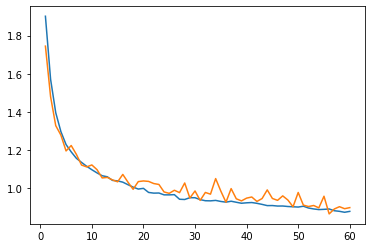

In [38]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), losses, label='training loss')
plt.plot(np.arange(1, EPOCHS+1), valid_losses, label='validation loss')
plt.show()

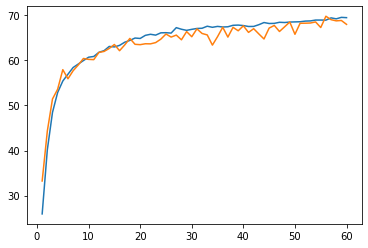

In [39]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), accs, label='training accuracy')
plt.plot(np.arange(1, EPOCHS+1), valid_accs, label='validation accuracy')
plt.show()

In [40]:
test(resnet34, testloader, device)

Accuracy of the network on 10000 test images: 68.0 %


In [20]:
resnet50 = resnet.resnet50().to(device)

In [21]:
summary(resnet50, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           4,800
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [22]:
loss_ftn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(resnet50.parameters(), lr=0.01, weight_decay=0.001)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: (0.95 ** epoch) * (0.5 ** int(epoch//5)),
#                                         last_epoch=-1,
#                                         verbose=True)
optimizer = optim.SGD(resnet50.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-01.


In [23]:
EPOCHS=60

losses, accs, valid_losses, valid_accs = train(resnet50, trainloader, validloader, EPOCHS, device, 
                                               loss_ftn, optimizer, scheduler=scheduler)

352it [00:21, 16.63it/s]


EPOCH 1 Completed. 
 Training Loss: 1.912, Training Accuracy: 31.16, Validation Loss: 1.599, Validation Accuracy: 39.94 

Adjusting learning rate of group 0 to 9.9994e-02.


352it [00:24, 14.19it/s]


EPOCH 2 Completed. 
 Training Loss: 1.452, Training Accuracy: 46.59, Validation Loss: 1.353, Validation Accuracy: 49.70 

Adjusting learning rate of group 0 to 9.9975e-02.


352it [00:29, 11.82it/s]


EPOCH 3 Completed. 
 Training Loss: 1.256, Training Accuracy: 54.66, Validation Loss: 1.204, Validation Accuracy: 56.38 

Adjusting learning rate of group 0 to 9.9944e-02.


352it [00:29, 11.90it/s]


EPOCH 4 Completed. 
 Training Loss: 1.112, Training Accuracy: 60.80, Validation Loss: 1.063, Validation Accuracy: 62.92 

Adjusting learning rate of group 0 to 9.9901e-02.


352it [00:29, 11.93it/s]


EPOCH 5 Completed. 
 Training Loss: 1.003, Training Accuracy: 64.50, Validation Loss: 0.963, Validation Accuracy: 66.26 

Adjusting learning rate of group 0 to 9.9846e-02.


352it [00:29, 11.88it/s]


EPOCH 6 Completed. 
 Training Loss: 0.926, Training Accuracy: 67.48, Validation Loss: 0.901, Validation Accuracy: 68.80 

Adjusting learning rate of group 0 to 9.9778e-02.


352it [00:29, 11.88it/s]


EPOCH 7 Completed. 
 Training Loss: 0.860, Training Accuracy: 70.08, Validation Loss: 0.848, Validation Accuracy: 70.86 

Adjusting learning rate of group 0 to 9.9698e-02.


352it [00:29, 11.91it/s]


EPOCH 8 Completed. 
 Training Loss: 0.796, Training Accuracy: 72.38, Validation Loss: 0.759, Validation Accuracy: 73.94 

Adjusting learning rate of group 0 to 9.9606e-02.


352it [00:29, 11.87it/s]


EPOCH 9 Completed. 
 Training Loss: 0.750, Training Accuracy: 73.86, Validation Loss: 0.740, Validation Accuracy: 74.84 

Adjusting learning rate of group 0 to 9.9501e-02.


352it [00:29, 11.96it/s]


EPOCH 10 Completed. 
 Training Loss: 0.723, Training Accuracy: 75.25, Validation Loss: 0.715, Validation Accuracy: 75.58 

Adjusting learning rate of group 0 to 9.9384e-02.


352it [00:28, 12.36it/s]


EPOCH 11 Completed. 
 Training Loss: 0.696, Training Accuracy: 76.32, Validation Loss: 0.763, Validation Accuracy: 74.10 

Adjusting learning rate of group 0 to 9.9255e-02.


352it [00:20, 17.02it/s]


EPOCH 12 Completed. 
 Training Loss: 0.669, Training Accuracy: 77.14, Validation Loss: 0.748, Validation Accuracy: 74.56 

Adjusting learning rate of group 0 to 9.9114e-02.


352it [00:27, 12.99it/s]


EPOCH 13 Completed. 
 Training Loss: 0.660, Training Accuracy: 77.40, Validation Loss: 0.676, Validation Accuracy: 76.52 

Adjusting learning rate of group 0 to 9.8961e-02.


352it [00:29, 11.92it/s]


EPOCH 14 Completed. 
 Training Loss: 0.645, Training Accuracy: 78.05, Validation Loss: 0.694, Validation Accuracy: 76.40 

Adjusting learning rate of group 0 to 9.8796e-02.


352it [00:29, 11.89it/s]


EPOCH 15 Completed. 
 Training Loss: 0.630, Training Accuracy: 78.44, Validation Loss: 0.679, Validation Accuracy: 77.14 

Adjusting learning rate of group 0 to 9.8618e-02.


352it [00:29, 11.94it/s]


EPOCH 16 Completed. 
 Training Loss: 0.612, Training Accuracy: 78.92, Validation Loss: 0.701, Validation Accuracy: 76.34 

Adjusting learning rate of group 0 to 9.8429e-02.


352it [00:29, 11.92it/s]


EPOCH 17 Completed. 
 Training Loss: 0.618, Training Accuracy: 78.85, Validation Loss: 0.672, Validation Accuracy: 77.44 

Adjusting learning rate of group 0 to 9.8228e-02.


352it [00:29, 11.89it/s]


EPOCH 18 Completed. 
 Training Loss: 0.605, Training Accuracy: 79.44, Validation Loss: 0.659, Validation Accuracy: 77.16 

Adjusting learning rate of group 0 to 9.8015e-02.


352it [00:29, 11.89it/s]


EPOCH 19 Completed. 
 Training Loss: 0.602, Training Accuracy: 79.21, Validation Loss: 0.661, Validation Accuracy: 77.12 

Adjusting learning rate of group 0 to 9.7790e-02.


352it [00:29, 12.01it/s]


EPOCH 20 Completed. 
 Training Loss: 0.586, Training Accuracy: 79.98, Validation Loss: 0.692, Validation Accuracy: 76.38 

Adjusting learning rate of group 0 to 9.7553e-02.


352it [00:29, 12.03it/s]


EPOCH 21 Completed. 
 Training Loss: 0.577, Training Accuracy: 80.39, Validation Loss: 0.607, Validation Accuracy: 79.68 

Adjusting learning rate of group 0 to 9.7304e-02.


352it [00:29, 11.84it/s]


EPOCH 22 Completed. 
 Training Loss: 0.584, Training Accuracy: 80.12, Validation Loss: 0.605, Validation Accuracy: 79.40 

Adjusting learning rate of group 0 to 9.7044e-02.


352it [00:29, 11.95it/s]


EPOCH 23 Completed. 
 Training Loss: 0.574, Training Accuracy: 80.56, Validation Loss: 0.590, Validation Accuracy: 79.50 

Adjusting learning rate of group 0 to 9.6772e-02.


352it [00:27, 12.84it/s]


EPOCH 24 Completed. 
 Training Loss: 0.559, Training Accuracy: 81.03, Validation Loss: 0.611, Validation Accuracy: 79.66 

Adjusting learning rate of group 0 to 9.6489e-02.


352it [00:20, 17.02it/s]


EPOCH 25 Completed. 
 Training Loss: 0.559, Training Accuracy: 80.88, Validation Loss: 0.602, Validation Accuracy: 79.20 

Adjusting learning rate of group 0 to 9.6194e-02.


352it [00:20, 17.03it/s]


EPOCH 26 Completed. 
 Training Loss: 0.548, Training Accuracy: 81.42, Validation Loss: 0.616, Validation Accuracy: 79.26 

Adjusting learning rate of group 0 to 9.5888e-02.


352it [00:20, 16.98it/s]


EPOCH 27 Completed. 
 Training Loss: 0.545, Training Accuracy: 81.33, Validation Loss: 0.672, Validation Accuracy: 77.26 

Adjusting learning rate of group 0 to 9.5570e-02.


352it [00:20, 16.98it/s]


EPOCH 28 Completed. 
 Training Loss: 0.543, Training Accuracy: 81.35, Validation Loss: 0.609, Validation Accuracy: 79.54 

Adjusting learning rate of group 0 to 9.5241e-02.


352it [00:20, 17.01it/s]


EPOCH 29 Completed. 
 Training Loss: 0.540, Training Accuracy: 81.65, Validation Loss: 0.568, Validation Accuracy: 80.48 

Adjusting learning rate of group 0 to 9.4901e-02.


352it [00:20, 16.98it/s]


EPOCH 30 Completed. 
 Training Loss: 0.541, Training Accuracy: 81.58, Validation Loss: 0.611, Validation Accuracy: 79.44 

Adjusting learning rate of group 0 to 9.4550e-02.


352it [00:20, 17.07it/s]


EPOCH 31 Completed. 
 Training Loss: 0.523, Training Accuracy: 82.24, Validation Loss: 0.610, Validation Accuracy: 79.48 

Adjusting learning rate of group 0 to 9.4188e-02.


352it [00:20, 16.98it/s]


EPOCH 32 Completed. 
 Training Loss: 0.533, Training Accuracy: 81.81, Validation Loss: 0.599, Validation Accuracy: 78.76 

Adjusting learning rate of group 0 to 9.3815e-02.


352it [00:20, 16.84it/s]


EPOCH 33 Completed. 
 Training Loss: 0.521, Training Accuracy: 82.27, Validation Loss: 0.622, Validation Accuracy: 78.58 

Adjusting learning rate of group 0 to 9.3432e-02.


352it [00:20, 16.99it/s]


EPOCH 34 Completed. 
 Training Loss: 0.511, Training Accuracy: 82.46, Validation Loss: 0.593, Validation Accuracy: 80.16 

Adjusting learning rate of group 0 to 9.3037e-02.


352it [00:20, 17.03it/s]


EPOCH 35 Completed. 
 Training Loss: 0.517, Training Accuracy: 82.38, Validation Loss: 0.552, Validation Accuracy: 81.30 

Adjusting learning rate of group 0 to 9.2632e-02.


352it [00:20, 16.96it/s]


EPOCH 36 Completed. 
 Training Loss: 0.516, Training Accuracy: 82.57, Validation Loss: 0.544, Validation Accuracy: 81.38 

Adjusting learning rate of group 0 to 9.2216e-02.


352it [00:20, 17.03it/s]


EPOCH 37 Completed. 
 Training Loss: 0.510, Training Accuracy: 82.67, Validation Loss: 0.585, Validation Accuracy: 79.84 

Adjusting learning rate of group 0 to 9.1790e-02.


352it [00:20, 16.96it/s]


EPOCH 38 Completed. 
 Training Loss: 0.511, Training Accuracy: 82.62, Validation Loss: 0.548, Validation Accuracy: 80.94 

Adjusting learning rate of group 0 to 9.1354e-02.


352it [00:20, 16.98it/s]


EPOCH 39 Completed. 
 Training Loss: 0.513, Training Accuracy: 82.47, Validation Loss: 0.553, Validation Accuracy: 81.58 

Adjusting learning rate of group 0 to 9.0907e-02.


352it [00:20, 16.95it/s]


EPOCH 40 Completed. 
 Training Loss: 0.503, Training Accuracy: 82.74, Validation Loss: 0.566, Validation Accuracy: 80.86 

Adjusting learning rate of group 0 to 9.0451e-02.


352it [00:20, 16.95it/s]


EPOCH 41 Completed. 
 Training Loss: 0.499, Training Accuracy: 82.84, Validation Loss: 0.592, Validation Accuracy: 80.06 

Adjusting learning rate of group 0 to 8.9984e-02.


352it [00:20, 16.98it/s]


EPOCH 42 Completed. 
 Training Loss: 0.496, Training Accuracy: 83.20, Validation Loss: 0.556, Validation Accuracy: 81.24 

Adjusting learning rate of group 0 to 8.9508e-02.


352it [00:20, 17.04it/s]


EPOCH 43 Completed. 
 Training Loss: 0.493, Training Accuracy: 83.21, Validation Loss: 0.539, Validation Accuracy: 81.42 

Adjusting learning rate of group 0 to 8.9022e-02.


352it [00:20, 17.00it/s]


EPOCH 44 Completed. 
 Training Loss: 0.492, Training Accuracy: 83.23, Validation Loss: 0.526, Validation Accuracy: 82.50 

Adjusting learning rate of group 0 to 8.8526e-02.


352it [00:20, 16.99it/s]


EPOCH 45 Completed. 
 Training Loss: 0.485, Training Accuracy: 83.43, Validation Loss: 0.527, Validation Accuracy: 81.68 

Adjusting learning rate of group 0 to 8.8020e-02.


352it [00:20, 16.99it/s]


EPOCH 46 Completed. 
 Training Loss: 0.480, Training Accuracy: 83.77, Validation Loss: 0.579, Validation Accuracy: 80.38 

Adjusting learning rate of group 0 to 8.7506e-02.


352it [00:20, 16.98it/s]


EPOCH 47 Completed. 
 Training Loss: 0.484, Training Accuracy: 83.45, Validation Loss: 0.530, Validation Accuracy: 82.02 

Adjusting learning rate of group 0 to 8.6982e-02.


352it [00:20, 17.07it/s]


EPOCH 48 Completed. 
 Training Loss: 0.478, Training Accuracy: 83.52, Validation Loss: 0.566, Validation Accuracy: 81.26 

Adjusting learning rate of group 0 to 8.6448e-02.


352it [00:20, 17.05it/s]


EPOCH 49 Completed. 
 Training Loss: 0.472, Training Accuracy: 84.00, Validation Loss: 0.530, Validation Accuracy: 81.88 

Adjusting learning rate of group 0 to 8.5906e-02.


352it [00:20, 17.01it/s]


EPOCH 50 Completed. 
 Training Loss: 0.471, Training Accuracy: 83.91, Validation Loss: 0.502, Validation Accuracy: 82.98 

Adjusting learning rate of group 0 to 8.5355e-02.


352it [00:20, 17.03it/s]


EPOCH 51 Completed. 
 Training Loss: 0.465, Training Accuracy: 84.14, Validation Loss: 0.512, Validation Accuracy: 82.48 

Adjusting learning rate of group 0 to 8.4796e-02.


352it [00:20, 17.01it/s]


EPOCH 52 Completed. 
 Training Loss: 0.470, Training Accuracy: 84.06, Validation Loss: 0.516, Validation Accuracy: 82.70 

Adjusting learning rate of group 0 to 8.4227e-02.


352it [00:20, 16.99it/s]


EPOCH 53 Completed. 
 Training Loss: 0.465, Training Accuracy: 83.86, Validation Loss: 0.526, Validation Accuracy: 82.14 

Adjusting learning rate of group 0 to 8.3651e-02.


352it [00:20, 16.95it/s]


EPOCH 54 Completed. 
 Training Loss: 0.457, Training Accuracy: 84.44, Validation Loss: 0.532, Validation Accuracy: 81.96 

Adjusting learning rate of group 0 to 8.3066e-02.


352it [00:20, 16.98it/s]


EPOCH 55 Completed. 
 Training Loss: 0.462, Training Accuracy: 84.30, Validation Loss: 0.574, Validation Accuracy: 80.38 

Adjusting learning rate of group 0 to 8.2472e-02.


352it [00:20, 17.04it/s]


EPOCH 56 Completed. 
 Training Loss: 0.455, Training Accuracy: 84.51, Validation Loss: 0.495, Validation Accuracy: 82.50 

Adjusting learning rate of group 0 to 8.1871e-02.


352it [00:20, 16.97it/s]


EPOCH 57 Completed. 
 Training Loss: 0.447, Training Accuracy: 84.67, Validation Loss: 0.531, Validation Accuracy: 81.78 

Adjusting learning rate of group 0 to 8.1262e-02.


352it [00:20, 16.87it/s]


EPOCH 58 Completed. 
 Training Loss: 0.445, Training Accuracy: 84.73, Validation Loss: 0.568, Validation Accuracy: 81.02 

Adjusting learning rate of group 0 to 8.0645e-02.


352it [00:20, 16.99it/s]


EPOCH 59 Completed. 
 Training Loss: 0.448, Training Accuracy: 84.90, Validation Loss: 0.507, Validation Accuracy: 82.62 

Adjusting learning rate of group 0 to 8.0021e-02.


352it [00:20, 16.98it/s]


EPOCH 60 Completed. 
 Training Loss: 0.448, Training Accuracy: 84.70, Validation Loss: 0.456, Validation Accuracy: 84.34 

Adjusting learning rate of group 0 to 7.9389e-02.


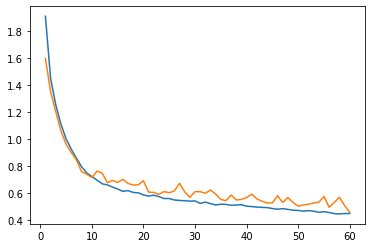

In [24]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), losses, label='training loss')
plt.plot(np.arange(1, EPOCHS+1), valid_losses, label='validation loss')
plt.show()

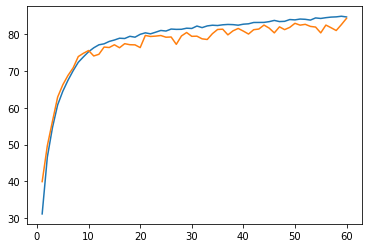

In [25]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), accs, label='training accuracy')
plt.plot(np.arange(1, EPOCHS+1), valid_accs, label='validation accuracy')
plt.show()

In [26]:
test(resnet50, testloader, device)

Accuracy of the network on 10000 test images: 82.31 %
